<br>
<br>
**<font size=5><center>Predicting Default Rates for Lending Club</center></font>**

### Authors:
Devon Luongo <br>
Ankit Agarwal <br>
Bryn Clarke <br>
Ben Yuen

# IV. Baseline Models

*Libraries*

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA

In [ ]:
df_X = pd.read_pickle("./data/df_X_imputed.pkl")
df_X = df_X.drop(["verification_status_None", "term_None", "application_type_None", "initial_list_status_None", "purpose_None", "emp_length_None", "home_ownership_None", "addr_state_None", "funded_amnt_inv", "num_actv_rev_tl", "tot_cur_bal"], axis=1)
df_y = pd.read_pickle("./data/df_y.pkl")

In [3]:
sclr = StandardScaler()
X = sclr.fit_transform(df_X)
y = df_y.values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20161201)

In [20]:
pca = PCA(n_components=100)
pca.fit(X)

for n in range(5, 105, 5):
    print "%d-components: %.2f%% variance explained" % (n, sum(pca.explained_variance_ratio_[1:n])*100)

5-components: 10.91% variance explained
10-components: 18.61% variance explained
15-components: 24.24% variance explained
20-components: 28.70% variance explained
25-components: 32.46% variance explained
30-components: 35.90% variance explained
35-components: 39.22% variance explained
40-components: 42.48% variance explained
45-components: 45.69% variance explained
50-components: 48.87% variance explained
55-components: 52.02% variance explained
60-components: 55.16% variance explained
65-components: 58.29% variance explained
70-components: 61.41% variance explained
75-components: 64.51% variance explained
80-components: 67.61% variance explained
85-components: 70.69% variance explained
90-components: 73.77% variance explained
95-components: 76.83% variance explained
100-components: 79.84% variance explained


In [45]:
n = 40
pca = PCA(n_components=n)
X_pc = pca.fit_transform(X)
print "%d-components: %.2f%% variance explained" % (n, sum(pca.explained_variance_ratio_)*100)
X_pc_train, X_pc_test, y_pc_train, y_pc_test = train_test_split(X_pc, y, test_size=0.3, random_state=20161201)

40-components: 48.01% variance explained


In [36]:
# Baseline models
# All positive (label every applicant as default)
class Pos_model(object):
    def fit(self, X, y):
        return
    
    def predict(self, x):
        return np.array([1] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

pos_model = Pos_model()
pos_model.fit(X_train, y_train)
pos_model.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [37]:
# All negative (label every applicant as not default)
class Neg_model(object):
    def fit(self, X, y):
        return
    
    def predict(self, x):
        return np.array([0] * len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

neg_model = Neg_model()
neg_model.fit(X_train, y_train)
neg_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
# Random (randomly predict flu or not flu)
class Random_model(object):
    def fit(self, X, y):
        return
    
    def predict(self, x):
        return np.random.randint(0, 2, len(x))
    
    def score(self, x, y):
        y_pred = self.predict(x)
        y_err = y - y_pred
        return len(y_err[y_err == 0]) * 1. / len(y_err)

random_model = Random_model()
random_model.fit(X_train, y_train)
random_model.predict(X_test)

array([0, 1, 1, ..., 1, 1, 1])

In [34]:
def custom_cost(y, y_pred):
    cost_fixed_application = 10.0
    cost_fixed_servicing = 100.0
    cost_default = 15000.0
    cost_interest = -1000.0
    
    # TRUE POSITIVE: Predict default, applicant would default
    n_true_positive = sum((y==1) & (y_pred==1))
    # We only pay fixed application processing costs as we decline the loan
    cost_true_positive = n_true_positive*(cost_fixed_application)
    
    # TRUE NEGATIVE: Predict pay on time, applicant will pay on time
    n_true_negative = sum((y==0) & (y_pred==0))
    # We pay fixed application processing costs, costs of servicing the loan, and gain profit on interest payments
    cost_true_negative = n_true_negative*(cost_fixed_application + cost_fixed_servicing + cost_interest)
    
    # FALSE POSITIVE: Predict default, applicant would pay on time
    n_false_positive = sum((y==0) & (y_pred==1))
    # We only pay fixed application processing costs as we decline the loan
    cost_false_positive = n_false_positive*(cost_fixed_application)
    
    # FALSE NEGATIVE: Predict pay on time, applicant will default
    n_false_negative = sum((y==1) & (y_pred==0))
    # We pay fixed application processing costs, costs of servicing the loan, and the principal as the loan defaults
    cost_false_negative = n_false_negative*(cost_fixed_application + cost_fixed_servicing + cost_default)
    
    return (cost_true_positive + cost_true_negative + cost_false_positive + cost_false_negative)/len(y)

In [32]:
def test_model(model, label, scoring_funcs, use_pc=True):
    if use_pc:
        model.fit(X_pc_train, y_train)
        y_pred = model.predict(X_pc_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)        
        
    scores = {"model": label}
    for scoring_func in scoring_funcs:
        scores[scoring_func.__name__] = scoring_func(y_test, y_pred)
    
    return pd.DataFrame([scores]).set_index("model")

def compare_models(models, labels, scoring_funcs, use_pc=True):
    return pd.concat([test_model(model, label, scoring_funcs, use_pc) for model, label in zip(models, labels)])

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

compare_models([pos_model, neg_model, random_model], ["Positive Model", "Negative Model", "Random Model"], [custom_cost, accuracy_score, average_precision_score, f1_score, log_loss, precision_score, recall_score, roc_auc_score])

/home/ubuntu/anaconda3/envs/cs109a_proj/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/cs109a_proj/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,accuracy_score,average_precision_score,custom_cost,f1_score,log_loss,precision_score,recall_score,roc_auc_score
model,,,,,,,,
Positive Model,0.196514,0.598257,10.000000,0.328477,27.752072,0.196514,1.000000,0.500000
Negative Model,0.803486,0.598257,2254.220934,0.000000,6.787346,0.000000,0.000000,0.500000
Random Model,0.500213,0.395448,1142.509376,0.280685,17.262349,0.195689,0.496205,0.498699


# V. Prediction Models

In [18]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
compare_models([logreg], ["Logistic Regression"], [custom_cost, accuracy_score, average_precision_score, f1_score, log_loss, precision_score, recall_score, roc_auc_score])

,accuracy_score,average_precision_score,custom_cost,f1_score,log_loss,precision_score,recall_score,roc_auc_score
model,,,,,,,,
Logistic Regression,0.822554,0.50766,1647.854586,0.318649,6.128796,0.649153,0.211147,0.591618


In [44]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda__svd__None__None = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=None)
lda__lsqr__None__None = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None, priors=None)
lda__lsqr__auto__None = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=None)
lda__lsqr__auto__0_95 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.95, 0.05])
lda__lsqr__auto__0_9 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.9, 0.1])
lda__lsqr__auto__0_85 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.85, 0.15])
lda__lsqr__auto__0_8 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.8, 0.2])
lda__lsqr__auto__0_75 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.75, 0.25])
lda__lsqr__auto__0_7 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.7, 0.3])
lda__lsqr__auto__0_65 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.65, 0.35])
lda__lsqr__auto__0_6 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.6, 0.4])
lda__lsqr__auto__0_55 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.55, 0.45])
lda__lsqr__auto__0_5 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.5, 0.5])
lda__lsqr__auto__0_45 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.45, 0.55])
lda__lsqr__auto__0_4 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.4, 0.6])
lda__lsqr__auto__0_35 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.35, 0.65])
lda__lsqr__auto__0_3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.3, 0.7])
lda__lsqr__auto__0_25 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.25, 0.75])
lda__lsqr__auto__0_2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.2, 0.8])
lda__lsqr__auto__0_15 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.15, 0.85])
lda__lsqr__auto__0_1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.1, 0.9])
lda__lsqr__auto__0_05 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', priors=[0.05, 0.95])

lda_search = compare_models([lda__svd__None__None,
                            lda__lsqr__None__None,
                            lda__lsqr__auto__None,
                            lda__lsqr__auto__0_95,
                            lda__lsqr__auto__0_9,
                            lda__lsqr__auto__0_85,
                            lda__lsqr__auto__0_8,
                            lda__lsqr__auto__0_75,
                            lda__lsqr__auto__0_7,
                            lda__lsqr__auto__0_65,
                            lda__lsqr__auto__0_6,
                            lda__lsqr__auto__0_55,
                            lda__lsqr__auto__0_5,
                            lda__lsqr__auto__0_45,
                            lda__lsqr__auto__0_4,
                            lda__lsqr__auto__0_35,
                            lda__lsqr__auto__0_3,
                            lda__lsqr__auto__0_25,
                            lda__lsqr__auto__0_2,
                            lda__lsqr__auto__0_15,
                            lda__lsqr__auto__0_1,
                            lda__lsqr__auto__0_05],
                           ["lda__svd__None__None",
                            "lda__lsqr__None__None",
                            "lda__lsqr__auto__None",
                            "lda__lsqr__auto__0_95",
                            "lda__lsqr__auto__0_9",
                            "lda__lsqr__auto__0_85",
                            "lda__lsqr__auto__0_8",
                            "lda__lsqr__auto__0_75",
                            "lda__lsqr__auto__0_7",
                            "lda__lsqr__auto__0_65",
                            "lda__lsqr__auto__0_6",
                            "lda__lsqr__auto__0_55",
                            "lda__lsqr__auto__0_5",
                            "lda__lsqr__auto__0_45",
                            "lda__lsqr__auto__0_4",
                            "lda__lsqr__auto__0_35",
                            "lda__lsqr__auto__0_3",
                            "lda__lsqr__auto__0_25",
                            "lda__lsqr__auto__0_2",
                            "lda__lsqr__auto__0_15",
                            "lda__lsqr__auto__0_1",
                            "lda__lsqr__auto__0_05"],
                           [custom_cost,
                            accuracy_score,
                            average_precision_score,
                            f1_score,
                            log_loss,
                            precision_score,
                            recall_score,
                            roc_auc_score])

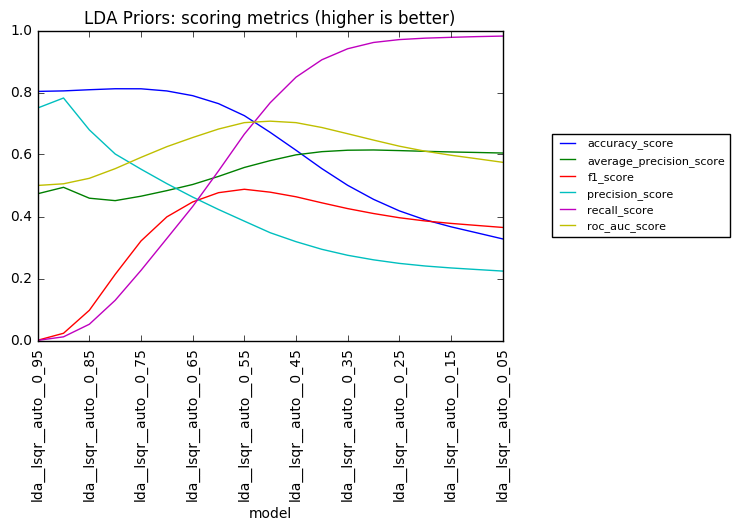

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
lda_search.ix[3:].drop(["custom_cost", "log_loss"], axis=1).plot()
plt.legend(loc='right', prop={'size':8}, bbox_to_anchor=(1.5,0.5))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("LDA Priors: scoring metrics (higher is better)")

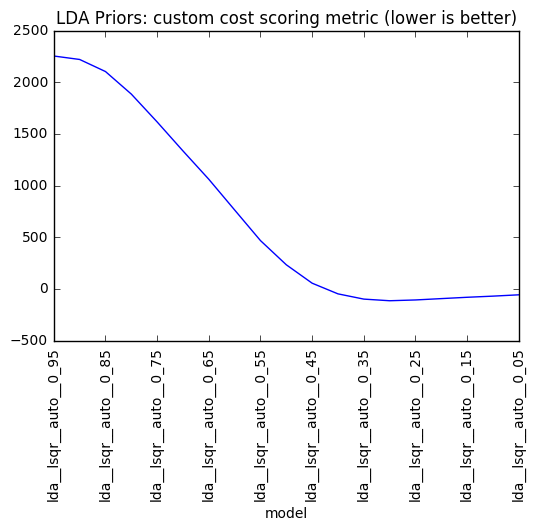

In [133]:
plt.figure()
lda_search.ix[3:].custom_cost.plot()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("LDA Priors: custom cost scoring metric (lower is better)")

In [129]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda__None__0 = QuadraticDiscriminantAnalysis(priors=None, reg_param=0)
qda__None__1En20 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-20))
qda__None__1En19 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-19))
qda__None__1En18 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-18))
qda__None__1En17 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-17))
qda__None__1En16 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-16))
qda__None__1En15 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-15))
qda__None__1En14 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-14))
qda__None__1En13 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-13))
qda__None__1En12 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-12))
qda__None__1En11 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-11))
qda__None__1En10 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-10))
qda__None__1En9 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-9))
qda__None__1En8 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-8))
qda__None__1En7 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-7))
qda__None__1En6 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-6))
qda__None__1En5 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-5))
qda__None__1En4 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-4))
qda__None__1En3 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-3))
qda__None__1En2 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-2))
qda__None__1En1 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(-1))
qda__None__1E0 = QuadraticDiscriminantAnalysis(priors=None, reg_param=10**(0))

qda_search_reg = compare_models([qda__None__0,
                                 qda__None__1En20,
                                 qda__None__1En19,
                                 qda__None__1En18,
                                 qda__None__1En17,
                                 qda__None__1En16,
                                 qda__None__1En15,
                                 qda__None__1En14,
                                 qda__None__1En13,
                                 qda__None__1En12,
                                 qda__None__1En11,
                                 qda__None__1En10,
                                 qda__None__1En9,
                                 qda__None__1En8,
                                 qda__None__1En7,
                                 qda__None__1En6,
                                 qda__None__1En5,
                                 qda__None__1En4,
                                 qda__None__1En3,
                                 qda__None__1En2,
                                 qda__None__1En1,
                                 qda__None__1E0],
                                ["qda__None__0",
                                 "qda__None__1En20",
                                 "qda__None__1En19",
                                 "qda__None__1En18",
                                 "qda__None__1En17",
                                 "qda__None__1En16",
                                 "qda__None__1En15",
                                 "qda__None__1En14",
                                 "qda__None__1En13",
                                 "qda__None__1En12",
                                 "qda__None__1En11",
                                 "qda__None__1En10",
                                 "qda__None__1En9",
                                 "qda__None__1En8",
                                 "qda__None__1En7",
                                 "qda__None__1En6",
                                 "qda__None__1En5",
                                 "qda__None__1En4",
                                 "qda__None__1En3",
                                 "qda__None__1En2",
                                 "qda__None__1En1",
                                 "qda__None__1E0"],
                                [custom_cost,
                                 accuracy_score,
                                 average_precision_score,
                                 f1_score,
                                 log_loss,
                                 precision_score,
                                 recall_score,
                                 roc_auc_score])

qda_search_reg

,accuracy_score,average_precision_score,custom_cost,f1_score,log_loss,precision_score,recall_score,roc_auc_score
model,,,,,,,,
qda__None__0,0.644016,0.333282,1522.407944,0.257238,12.295416,0.218009,0.313685,0.519246
qda__None__1En20,0.267687,0.587762,54.393113,0.340298,25.293786,0.206750,0.961136,0.529611
qda__None__1En19,0.271761,0.587257,56.535970,0.341064,25.153060,0.207412,0.959054,0.531360
qda__None__1En18,0.276091,0.586522,60.022162,0.341784,25.003502,0.208070,0.956409,0.533055
qda__None__1En17,0.280498,0.585902,62.834129,0.342586,24.851294,0.208781,0.953980,0.534880
qda__None__1En16,0.285194,0.585199,66.111490,0.343425,24.689077,0.209535,0.951290,0.536787
qda__None__1En15,0.290155,0.584895,66.972383,0.344544,24.517733,0.210462,0.949382,0.539153
qda__None__1En14,0.295414,0.584331,69.380327,0.345614,24.336085,0.211388,0.946823,0.541459
qda__None__1En13,0.301705,0.583675,72.191442,0.346917,24.118813,0.212517,0.943787,0.544227


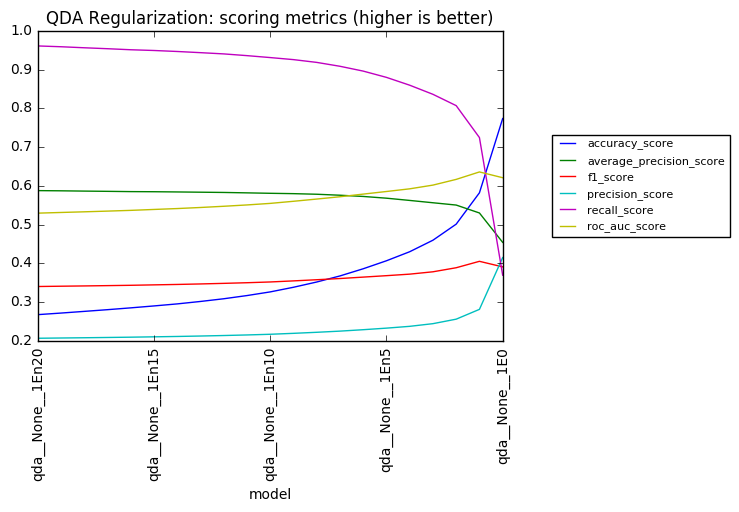

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt
qda_search_reg.ix[1:].drop(["custom_cost", "log_loss"], axis=1).plot()
plt.legend(loc='right', prop={'size':8}, bbox_to_anchor=(1.5,0.5))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("QDA Regularization: scoring metrics (higher is better)")

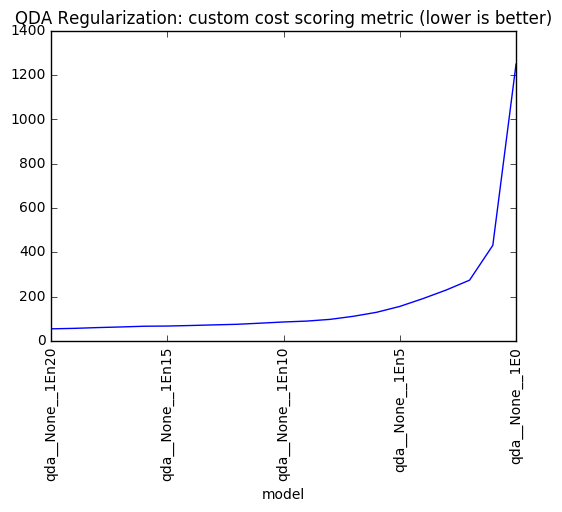

In [136]:
plt.figure()
qda_search_reg.ix[1:].custom_cost.plot()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("QDA Regularization: custom cost scoring metric (lower is better)")

In [130]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda__0_95__1En10 = QuadraticDiscriminantAnalysis(priors=[0.95, 0.05], reg_param=10**(-10))
qda__0_90__1En10 = QuadraticDiscriminantAnalysis(priors=[0.90, 0.10], reg_param=10**(-10))
qda__0_85__1En10 = QuadraticDiscriminantAnalysis(priors=[0.85, 0.15], reg_param=10**(-10))
qda__0_80__1En10 = QuadraticDiscriminantAnalysis(priors=[0.80, 0.20], reg_param=10**(-10))
qda__0_75__1En10 = QuadraticDiscriminantAnalysis(priors=[0.75, 0.25], reg_param=10**(-10))
qda__0_70__1En10 = QuadraticDiscriminantAnalysis(priors=[0.70, 0.30], reg_param=10**(-10))
qda__0_65__1En10 = QuadraticDiscriminantAnalysis(priors=[0.65, 0.35], reg_param=10**(-10))
qda__0_60__1En10 = QuadraticDiscriminantAnalysis(priors=[0.60, 0.40], reg_param=10**(-10))
qda__0_55__1En10 = QuadraticDiscriminantAnalysis(priors=[0.55, 0.45], reg_param=10**(-10))
qda__0_50__1En10 = QuadraticDiscriminantAnalysis(priors=[0.50, 0.50], reg_param=10**(-10))
qda__0_45__1En10 = QuadraticDiscriminantAnalysis(priors=[0.45, 0.55], reg_param=10**(-10))
qda__0_40__1En10 = QuadraticDiscriminantAnalysis(priors=[0.40, 0.60], reg_param=10**(-10))
qda__0_35__1En10 = QuadraticDiscriminantAnalysis(priors=[0.35, 0.65], reg_param=10**(-10))
qda__0_30__1En10 = QuadraticDiscriminantAnalysis(priors=[0.30, 0.70], reg_param=10**(-10))
qda__0_25__1En10 = QuadraticDiscriminantAnalysis(priors=[0.25, 0.75], reg_param=10**(-10))
qda__0_20__1En10 = QuadraticDiscriminantAnalysis(priors=[0.20, 0.80], reg_param=10**(-10))
qda__0_15__1En10 = QuadraticDiscriminantAnalysis(priors=[0.15, 0.85], reg_param=10**(-10))
qda__0_10__1En10 = QuadraticDiscriminantAnalysis(priors=[0.10, 0.90], reg_param=10**(-10))
qda__0_05__1En10 = QuadraticDiscriminantAnalysis(priors=[0.05, 0.95], reg_param=10**(-10))

qda_search_priors = compare_models([qda__0_95__1En10,
                                    qda__0_90__1En10,
                                    qda__0_85__1En10,
                                    qda__0_80__1En10,
                                    qda__0_75__1En10,
                                    qda__0_70__1En10,
                                    qda__0_65__1En10,
                                    qda__0_60__1En10,
                                    qda__0_55__1En10,
                                    qda__0_50__1En10,
                                    qda__0_45__1En10,
                                    qda__0_40__1En10,
                                    qda__0_35__1En10,
                                    qda__0_30__1En10,
                                    qda__0_25__1En10,
                                    qda__0_20__1En10,
                                    qda__0_15__1En10,
                                    qda__0_10__1En10,
                                    qda__0_05__1En10],
                                  ["qda__0_95__1En10",
                                   "qda__0_90__1En10",
                                   "qda__0_85__1En10",
                                   "qda__0_80__1En10",
                                   "qda__0_75__1En10",
                                   "qda__0_70__1En10",
                                   "qda__0_65__1En10",
                                   "qda__0_60__1En10",
                                   "qda__0_55__1En10",
                                   "qda__0_50__1En10",
                                   "qda__0_45__1En10",
                                   "qda__0_40__1En10",
                                   "qda__0_35__1En10",
                                   "qda__0_30__1En10",
                                   "qda__0_25__1En10",
                                   "qda__0_20__1En10",
                                   "qda__0_15__1En10",
                                   "qda__0_10__1En10",
                                   "qda__0_05__1En10"],
                                  [custom_cost,
                                   accuracy_score,
                                   average_precision_score,
                                   f1_score,
                                   log_loss,
                                   precision_score,
                                   recall_score,
                                   roc_auc_score])

qda_search_priors

,accuracy_score,average_precision_score,custom_cost,f1_score,log_loss,precision_score,recall_score,roc_auc_score
model,,,,,,,,
qda__0_95__1En10,0.342312,0.579588,90.958916,0.355733,22.716266,0.220269,0.923964,0.562009
qda__0_90__1En10,0.334206,0.580079,88.934538,0.353755,22.996245,0.218568,0.927304,0.558226
qda__0_85__1En10,0.329390,0.580527,86.853904,0.352674,23.162584,0.217617,0.929603,0.556097
qda__0_80__1En10,0.325955,0.580854,85.346062,0.351912,23.281230,0.216948,0.931251,0.554582
qda__0_75__1En10,0.323662,0.581088,84.262700,0.351414,23.360425,0.216508,0.932379,0.553581
qda__0_70__1En10,0.321608,0.581272,83.448687,0.350956,23.431376,0.216109,0.933333,0.552664
qda__0_65__1En10,0.319775,0.581769,80.740709,0.350722,23.494674,0.215849,0.934895,0.552113
qda__0_60__1En10,0.317934,0.581779,80.945278,0.350234,23.558265,0.215451,0.935415,0.551164
qda__0_55__1En10,0.316365,0.582048,79.572963,0.349954,23.612436,0.215186,0.936413,0.550565


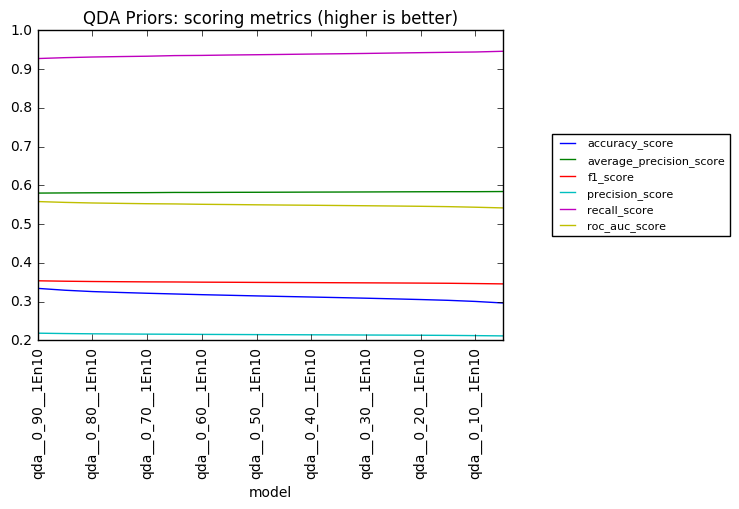

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
qda_search_priors.ix[1:].drop(["custom_cost", "log_loss"], axis=1).plot()
plt.legend(loc='right', prop={'size':8}, bbox_to_anchor=(1.5,0.5))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("QDA Priors: scoring metrics (higher is better)")

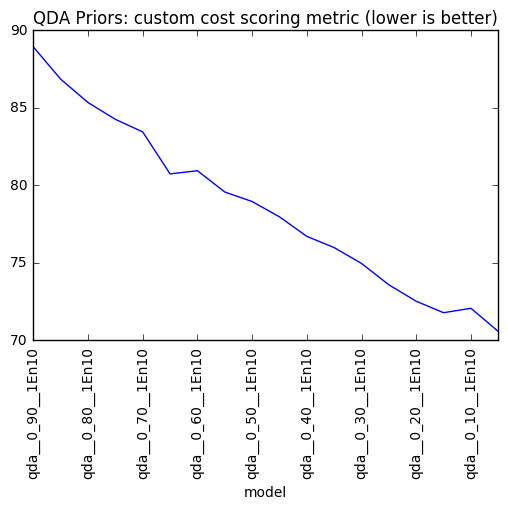

In [140]:
plt.figure()
qda_search_priors.ix[1:].custom_cost.plot()
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title("QDA Priors: custom cost scoring metric (lower is better)")

In [128]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda__0_06__1En30 = QuadraticDiscriminantAnalysis(priors=[0.06, 0.94], reg_param=10**(-30))
qda__0_07__1En30 = QuadraticDiscriminantAnalysis(priors=[0.07, 0.93], reg_param=10**(-30))
qda__0_08__1En30 = QuadraticDiscriminantAnalysis(priors=[0.08, 0.92], reg_param=10**(-30))
qda__0_06__1En29 = QuadraticDiscriminantAnalysis(priors=[0.06, 0.94], reg_param=10**(-29))
qda__0_07__1En29 = QuadraticDiscriminantAnalysis(priors=[0.07, 0.93], reg_param=10**(-29))
qda__0_08__1En29 = QuadraticDiscriminantAnalysis(priors=[0.08, 0.92], reg_param=10**(-29))
qda__0_06__1En28 = QuadraticDiscriminantAnalysis(priors=[0.06, 0.94], reg_param=10**(-28))
qda__0_07__1En28 = QuadraticDiscriminantAnalysis(priors=[0.07, 0.93], reg_param=10**(-28))
qda__0_08__1En28 = QuadraticDiscriminantAnalysis(priors=[0.08, 0.92], reg_param=10**(-28))

qda_search_optim = compare_models([qda__0_06__1En30,
                                   qda__0_07__1En30,
                                   qda__0_08__1En30,
                                   qda__0_06__1En29,
                                   qda__0_07__1En29,
                                   qda__0_08__1En29,
                                   qda__0_06__1En28,
                                   qda__0_07__1En28,
                                   qda__0_08__1En28],
                                  ["qda__0_06__1En30",
                                   "qda__0_07__1En30",
                                   "qda__0_08__1En30",
                                   "qda__0_06__1En29",
                                   "qda__0_07__1En29",
                                   "qda__0_08__1En29",
                                   "qda__0_06__1En28",
                                   "qda__0_07__1En28",
                                   "qda__0_08__1En28"],
                                  [custom_cost,
                                   accuracy_score,
                                   average_precision_score,
                                   f1_score,
                                   log_loss,
                                   precision_score,
                                   recall_score,
                                   roc_auc_score])

qda_search_optim

,accuracy_score,average_precision_score,custom_cost,f1_score,log_loss,precision_score,recall_score,roc_auc_score
model,,,,,,,,
qda__0_06__1En30,0.241297,0.590594,43.648142,0.335238,26.205265,0.202483,0.973498,0.517858
qda__0_07__1En30,0.241553,0.590602,43.539039,0.335303,26.196433,0.202532,0.973455,0.518001
qda__0_08__1En30,0.241783,0.590566,43.695022,0.335341,26.188484,0.202565,0.973325,0.518095
qda__0_06__1En29,0.239729,0.590688,43.486192,0.334907,26.259436,0.202217,0.974062,0.517095
qda__0_07__1En29,0.239968,0.590693,43.392431,0.334967,26.251192,0.202263,0.974019,0.517227
qda__0_08__1En29,0.240130,0.590610,43.851858,0.334965,26.245599,0.202270,0.973802,0.517246
qda__0_06__1En28,0.241084,0.590552,43.960961,0.335165,26.212625,0.202432,0.973455,0.517709
qda__0_07__1En28,0.241272,0.590471,44.397375,0.335171,26.206148,0.202445,0.973238,0.517744
qda__0_08__1En28,0.241544,0.590420,44.636038,0.335211,26.196727,0.202482,0.973064,0.517848


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=8)

knn_search = compare_models([knn],
                            ["knn"],
                            [custom_cost,
                             accuracy_score,
                             average_precision_score,
                             f1_score,
                             log_loss,
                             precision_score,
                             recall_score,
                             roc_auc_score],
                            True)

knn_search

In [ ]:
X_pc_train.shape